# PyTorch Computer Vision using custom dataset

## 1. Import Libraries

In [1]:
import os
import random
import zipfile
from pathlib import Path

import requests
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch

import torchvision
from torchvision import datasets, transforms

from torch.utils.data import DataLoader


print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

RAMDOM_SEED = 42

%load_ext autoreload
%autoreload 2

torch: 2.2.0
torchvision: 0.17.0


## 2. Get Dataset

### 2.1 Downloading dataset from url

In [2]:
# Setup path to data folder
data_dir = Path("data/")
image_dir = data_dir / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_dir.is_dir():
    print(f"{image_dir} directory exists.")
else:
    print(f"Did not find {image_dir} directory, creating one...")
    image_dir.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_dir / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza, steak, sushi data...")
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        )
        f.write(request.content)
        print("Downloading Done!")

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_dir / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_dir)
        print("Unzipping Done!")

data/pizza_steak_sushi directory exists.


### 2.2 Become one with the data (data preparation)

In [3]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str or pathlib.Path): target directory

    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames):3} images in '{dirpath}'."
        )

In [4]:
walk_through_dir(image_dir)

There are 2 directories and   0 images in 'data/pizza_steak_sushi'.
There are 3 directories and   0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and  72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and  75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and  78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and   0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and  31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and  19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and  25 images in 'data/pizza_steak_sushi/test/pizza'.


In [5]:
# Setup train and testing paths
train_dir = image_dir / "train"
test_dir = image_dir / "test"
image_path_list = list(image_dir.glob("*/*/*.jpg"))

print(f"image directory : {image_dir}")
print(f"train directory : {train_dir}")
print(f"test  directory : {test_dir}")
print(f"number of all images : {len(image_path_list)}")

image directory : data/pizza_steak_sushi
train directory : data/pizza_steak_sushi/train
test  directory : data/pizza_steak_sushi/test
number of all images : 300


### 2.3 Visualize an image

#### 2.3.1 Select a random image

In [6]:
random.seed(RAMDOM_SEED)

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

print(f"random image path    : '{random_image_path}'")
print(f"random image class   : {image_class}")

random image path    : 'data/pizza_steak_sushi/train/sushi/1957449.jpg'
random image class   : sushi


#### 2.3.2 Open image with `PIL`:

Image height : 512
Image width  : 512


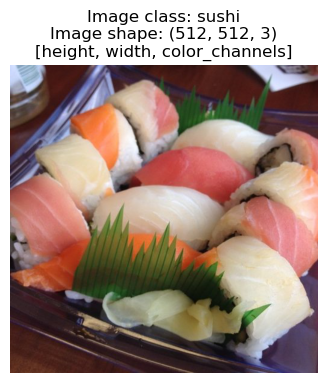

In [7]:
img = Image.open(random_image_path)

print(f"Image height : {img.height}")
print(f"Image width  : {img.width}")

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(img_as_array)
plt.title(
    f"Image class: {image_class}\nImage shape: {img_as_array.shape}\n[height, width, color_channels]"
)
plt.axis(False);

#### 2.3.3 Open image with `torchvision.io`:

Custom image shape: torch.Size([3, 512, 512])
Custom image dtype: torch.uint8


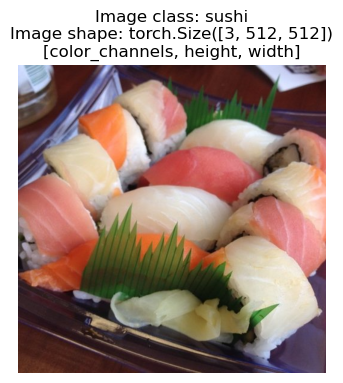

In [8]:
custom_image_uint8 = torchvision.io.read_image(str(random_image_path))

print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

plt.figure(figsize=(4, 4))
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # [height, width, color_channels]
plt.title(
    f"Image class: {image_class}\nImage shape: {custom_image_uint8.shape}\n[color_channels, height, width]"
)
plt.axis(False);

### 2.4 Visualizing the raw images

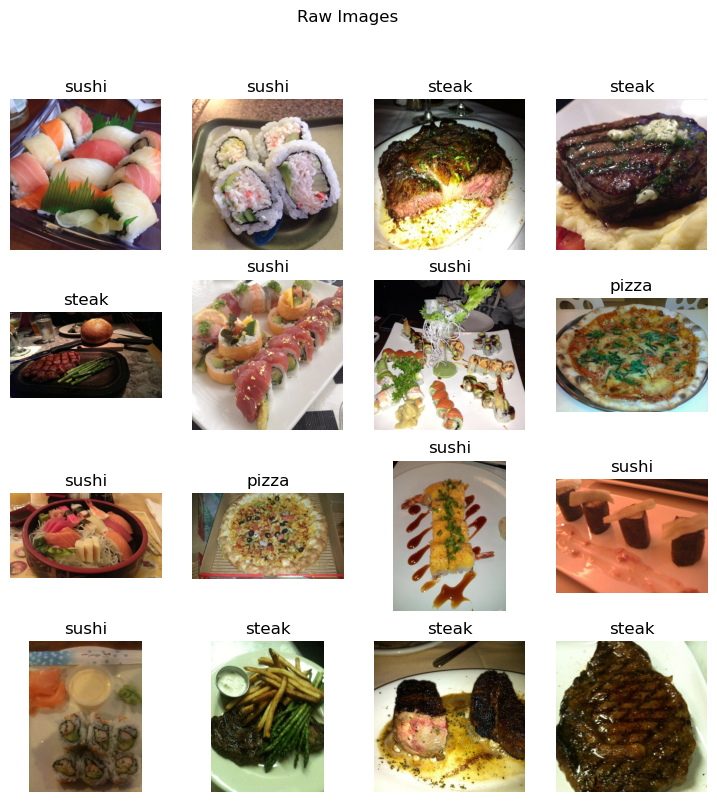

In [9]:
random.seed(RAMDOM_SEED)

rows, cols = 4, 4
random_image_paths = random.sample(image_path_list, k=rows*cols)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Raw Images")
plt.axis(False)
for i, image_path in enumerate(random_image_paths, start=1):
    label = image_path.parent.stem
    ax = fig.add_subplot(rows, cols, i)
    with Image.open(image_path) as img:
        plt.imshow(img)
    ax.set_title(label)
    ax.axis(False)

## 3. Transforming data


### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write transform for image.
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [11]:
transformed_img = data_transform(img) # input must be PIL object or numpy array object
transformed_img.shape, transformed_img.dtype

(torch.Size([3, 64, 64]), torch.float32)

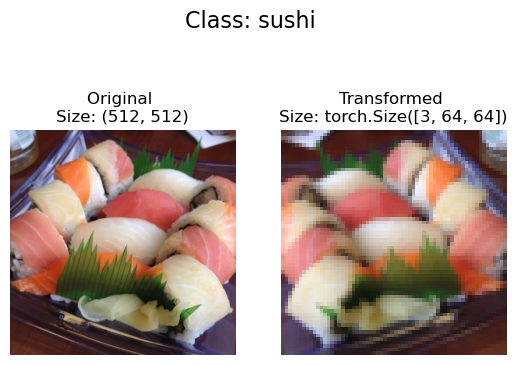

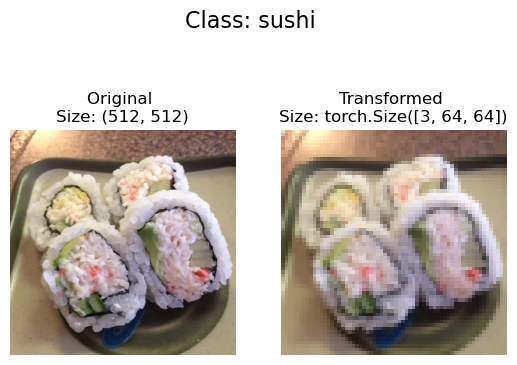

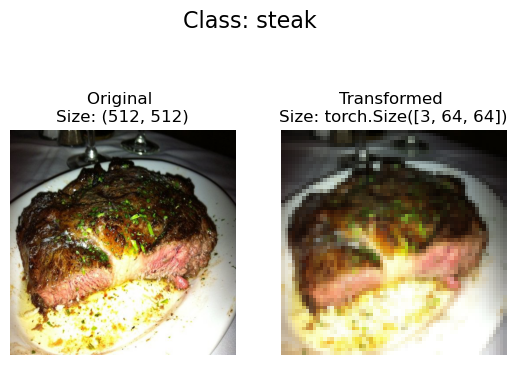

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed: int | None = None):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator.
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_path_list, transform=data_transform, n=3, seed=RAMDOM_SEED)

## 4. Loading train and test datasets Using `ImageFolder`

### 4.1 Creating `train_data` and `test_data`

In [13]:
# Use ImageFolder to create dataset(s)

train_data = datasets.ImageFolder(
    root=train_dir,  # target folder of images
    transform=data_transform,  # transforms to perform on data (images)
    target_transform=None, # transforms to perform on labels (if necessary)
)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


### 4.2 Dataset information

In [14]:
print(f"train data: {len(train_data)}")
print(f"test data : {len(test_data)}")

class_names = train_data.classes
NUM_CLASSES = len(class_names)
print(f"number of classes: {NUM_CLASSES}")
print(f"\nclass names:\n{class_names}")

class_to_idx = train_data.class_to_idx
print(f"\nclass to index:\n{class_to_idx}")

targets = train_data.targets
print(f"\nlength of targets:\n{len(targets)}")

image, label = train_data[0]
INPUT_IMAGE_SIZE = image.shape
print(f"\nimage shape:\n{INPUT_IMAGE_SIZE} -> [color_channels, height, width]")
print(f"\nimage index label:\n{label}")
print(f"\nimage label:\n{class_names[label]}")

train data: 225
test data : 75
number of classes: 3

class names:
['pizza', 'steak', 'sushi']

class to index:
{'pizza': 0, 'steak': 1, 'sushi': 2}

length of targets:
225

image shape:
torch.Size([3, 64, 64]) -> [color_channels, height, width]

image index label:
0

image label:
pizza


### 4.3 Visualizing transformed train images

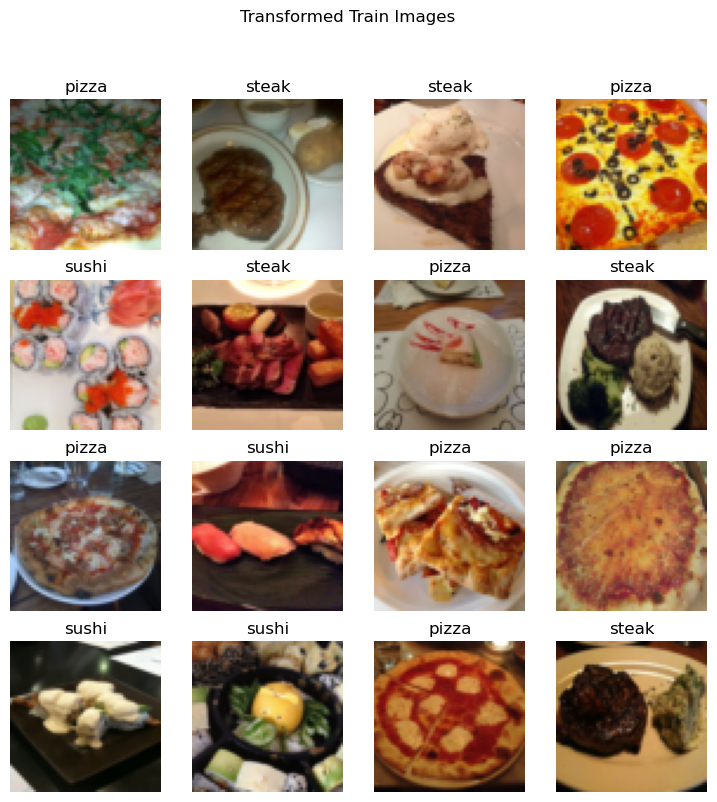

In [15]:
torch.manual_seed(RAMDOM_SEED)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Transformed Train Images")
plt.axis(False)
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    ax.set_title(class_names[label])
    ax.axis(False)

### 4.4 Visualizing transformed test images

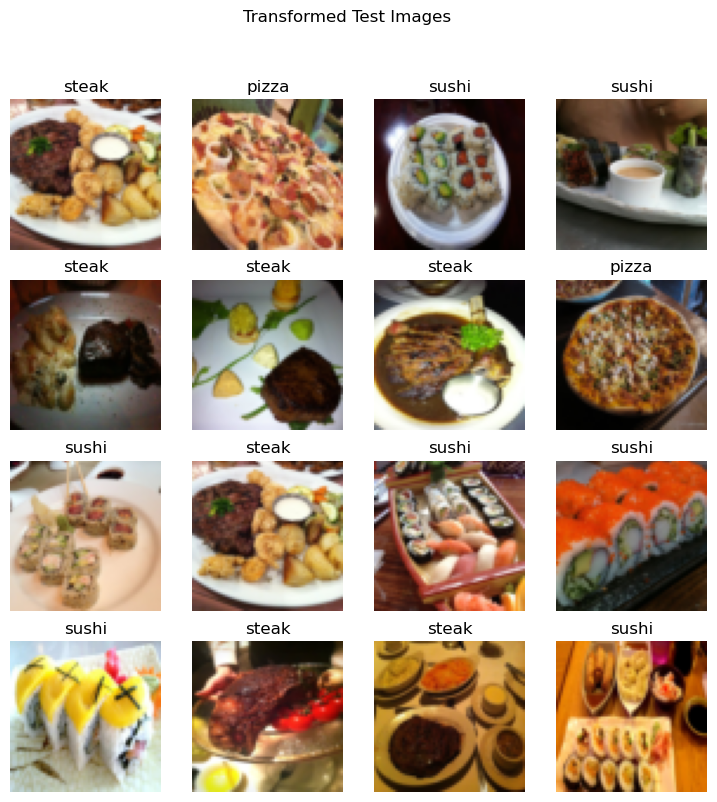

In [16]:
torch.manual_seed(RAMDOM_SEED)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Transformed Test Images")
plt.axis(False)
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label = test_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    ax.set_title(class_names[label])
    ax.axis(False)

## 5. Prepare DataLoader

### 5.1 Using `DataLoader()` to `turn_train` data and `test_data` into batches.

In [17]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False,
)

print(f"train dataloader: {train_dataloader}")
print(f"test Dataloader : {test_dataloader}")
print(f"length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} ({len(train_dataloader)*BATCH_SIZE})")
print(f"length of test dataloader : {len(test_dataloader)} batches of {BATCH_SIZE} ({len(test_dataloader)*BATCH_SIZE})")

train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f2803ce4940>
test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7f2803ce4640>
length of train dataloader: 29 batches of 8 (232)
length of test dataloader : 10 batches of 8 (80)


### 5.2 Details of one batch of images

In [18]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
print(f"train features batch shape: {train_features_batch.shape}")
print(f"train labels batch shape  : {train_labels_batch.shape}")

train features batch shape: torch.Size([8, 3, 64, 64])
train labels batch shape  : torch.Size([8])


Image size: torch.Size([3, 64, 64])
Label: 1


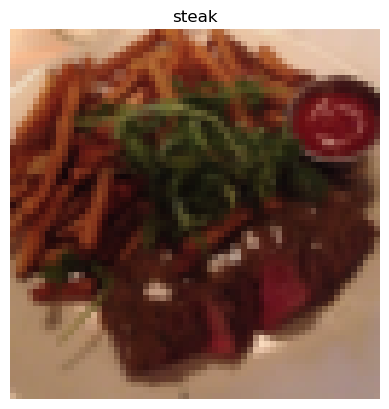

In [19]:
torch.manual_seed(RAMDOM_SEED)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}")